In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 22 14:42:56 2022
@author: uqczhan2
if hydraulic conductivity of the sandy layer
is reduced, the large hydraulic conductivity in the oscillating boundary
needs to be redued accordingLy_m 
"""

'\nCreated on Tue Feb 22 14:42:56 2022\n@author: uqczhan2\nif hydraulic conductivity of the sandy layer\nis reduced, the large hydraulic conductivity in the oscillating boundary\nneeds to be redued accordingLy_m \n'

In [2]:
import os
import sys
import glob
import platform
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

In [4]:
print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('pandas version: {}'.format(pd.__version__))
print('flopy version: {}'.format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.20.3
matplotlib version: 3.4.3
pandas version: 1.3.4
flopy version: 3.3.4


In [6]:
Lx_m   = 1000.    # from plot, y is plotted from left to right
Ly_m   = 10.     # from plot, y is plotted upward
ztop_m = 0.    # top elevation of z axis (gravity)
zbot_m = -20.  # bottom elevation of z axis (gravity)
nlay = 10    # number of layers (gravity)
nrow = 1     # number of rows
ncol = 10
delr_m = Lx_m / ncol
delc_m = Ly_m / nrow
delv_m = (ztop_m - zbot_m) / nlay             # layer thickness
botm_list_m = np.linspace(ztop_m, zbot_m, nlay + 1)  # layer elevation array
hk = np.ones((nlay, nrow, ncol), dtype=np.int32) * 10. #*30.   # making hydraulic conductivity array  [lay_row_column]
hk[:,:,0]= 100.           # first column has a very high hydraulic conductivity
vka = hk
sy = 0.25    # specific yield
ss = 1.e-4   #  specific storitivity 
laytyp = np.ones(nlay)   # vunconfined 1 

In [9]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) + 2    # [lay_row_column]
lay_id_chd = 9
row_id_chd = 0
col_id_chd = 0
ibound_chd = 1
ibound[lay_id_chd][row_id_chd][col_id_chd]=ibound_chd   # why do we need three layers here?? because the model is 3-d
#ibound[lay_id_chd][row_id_chd][1]=ibound_chd   # why do we need three layers here?? because the model is 3-d

In [10]:
# interesting to see that the it is better to be converged, if the head is above zero 
strt = 1. * np.ones((nlay, nrow, ncol), dtype=np.float32)   # initial hydraulic head
nper   = 3                  # number of stress periods
perlen = [100, 100, 100]  # length of stress periods  days 
nstp   = [100, 100, 100]   # number of steps per stress periods
steady = [False, False, False]   # if the results needs to be in steady state

In [12]:
modelname = 'tutorial2'
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr_m, delc=delc_m,
                                      top=ztop_m, botm=botm_list_m[1:],
                                      nper=nper, perlen=perlen, nstp=nstp, steady=steady,
                                      itmuni=4)   #itmuni 4 means time unit is days
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
# https://modflowpy.github.io/flopydoc/mflpf.html
lpf = flopy.modflow.ModflowLpf(mf, hk=hk, vka=vka, sy=sy, ss=ss, laytyp=laytyp, ipakcb=53,
        hdry=+1e-30,wetfct=0.1,iwetit=3,laywet=1,wetdry=-1)
pcg = flopy.modflow.ModflowPcg(mf)

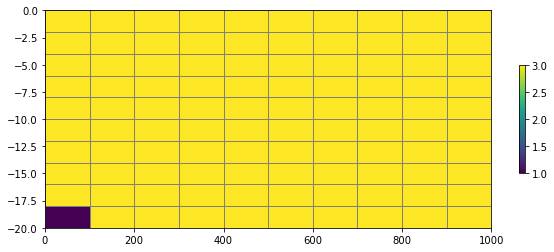

In [51]:
fig = plt.figure(figsize=(10, 4))
ax  = fig.add_subplot(1, 1, 1)
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(ibound)
modeLx_msect.plot_grid()
plt.colorbar(arr, shrink=0.5, ax=ax)

%%

is.sr.xcentergrid<br>
is.sr.ycentergrid<br>
is.sr.xgrid<br>
is.sr.ygrid<br>
p.ma.masked_equal(dis.sr.ygrid,1000) # very useful command to find specific file locations<br>
odelmap.sr.vertices<br>
lopy.plot.plotutil.cell_value_points<br>
<br>
<br>
odeLx_msect = flopy.plot.Modelc_mrossSection(model=mf, line={'Row': 0})<br>
odeLx_msect.elev<br>
<br>
odeLx_msect.dis<br>
odeLx_msect.xpts<br>
odeLx_msect.xcentergrid<br>
odeLx_msect.zcentergrid


<br>
from mpl_toolkits.mplot3d import Axes3D<br>
import matplotlib.pyplot as plt<br>
from matplotlib import cm<br>
from matplotlib.ticker import LinearLocator, FormatStrFormatter<br>
import numpy as np<br>
fig = plt.figure()<br>
ax = fig.gca(projection='3d')<br>
# Make data.<br>
X = np.arange(-5, 5, 0.25)<br>
Y = np.arange(-5, 5, 0.25)<br>
X, Y = np.meshgrid(X, Y)<br>
R = np.sqrt(X**2 + Y**2)<br>
Z = np.sin(R)<br>
# Plot the surface.<br>
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,<br>
                               linewidth=0, antialiased=False)<br>
# Customize the z axis.<br>
ax.set_zlim(-1.01, 1.01)<br>
ax.zaxis.set_major_locator(LinearLocator(10))<br>
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))<br>
# Add a color bar which maps values to colors.<br>
fig.colorbar(surf, shrink=0.5, aspect=5)<br>
plt.show()<br>


we are supposed to use CHD boundary here not GHB boundary


<br>
# Make list for stress period 1<br>
stageleft = 10.<br>
stageright = 10.<br>
bound_sp1 = []<br>
for il in range(nlay):<br>
    condleft = hk * (stageleft - zbot_m) * delc_m<br>
    condright = hk * (stageright - zbot_m) * delc_m<br>
    for ir in range(nrow):<br>
        bound_sp1.append([il, ir, 0, stageleft, condleft])<br>
        bound_sp1.append([il, ir, ncol - 1, stageright, condright])<br>
print('Adding ', len(bound_sp1), 'GHBs for stress period 1.')<br>
# Make list for stress period 2<br>
stageleft = 10.<br>
stageright = 0.<br>
condleft = hk * (stageleft - zbot_m) * delc_m<br>
condright = hk * (stageright - zbot_m) * delc_m<br>
bound_sp2 = []<br>
for il in range(nlay):<br>
    for ir in range(nrow):<br>
        bound_sp2.append([il, ir, 0, stageleft, condleft])<br>
        bound_sp2.append([il, ir, ncol - 1, stageright, condright])<br>
print('Adding ', len(bound_sp2), 'GHBs for stress period 2.')<br>
# We do not need to add a dictionary entry for stress period 3.<br>
# Flopy will automaticalLy_m take the list from stress period 2 and appLy_m it<br>
# to the end of the simulation, if necessary<br>
stress_period_data = {0: bound_sp1, 1: bound_sp2}<br>
# Create the flopy ghb object<br>
ghb = flopy.modflow.ModflowGhb(mf, stress_period_data=stress_period_data)<br>


hd={0:[<br>
      [0,0,0,1,2],<br>
      [0,0,2,1,2],<br>
      ]<br>
   }

In [21]:
ibound_chd_mask=np.ma.masked_equal(ibound,ibound_chd)
chd_node_index=np.where(ibound_chd_mask.mask)
stress_period_data = {}
bound_sp0 = []
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp0.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],0,0]  )
bound_sp1=[]
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp1.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],-10,-10]  )
bound_sp2=[]
for i in np.arange(np.sum(ibound_chd_mask.mask)):
   bound_sp2.append([chd_node_index[0][i],chd_node_index[1][i],chd_node_index[2][i],0,0]  )

In [23]:
stress_period_data={0:bound_sp0,1:bound_sp1,2:bound_sp2}

write to chd package

In [24]:
chd=flopy.modflow.mfchd.ModflowChd(model=mf,stress_period_data=stress_period_data)

lopy.modflow.mfchd.ModflowChd(model=mf,stress_period_data=chd)

In [25]:
stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        if np.mod(kstp,49)==0:
            stress_period_data[(kper, kstp)] = ['save head',
                                                'save drawdown',
                                                'save budget',
                                                'print head',
                                                'print budget']
            
oc = flopy.modflow.ModflowOc(mf, stress_period_data=stress_period_data,compact=True)

In [26]:
mf.write_input()

%%<br>
Run the model

In [27]:
success, mfoutput = mf.run_model(silent=True, pause=False, report=True)
if not success:
        raise Exception('MODFLOW did not terminate normalLy_m.')

In [29]:
headobj = bf.HeadFile(modelname+'.hds')
times_headobj = headobj.get_times()
cbbobj = bf.CellBudgetFile(modelname+'.cbc')
times_cbbobj = cbbobj.get_times()
# beginning of the first stress period
# end of the first stress period
#times_output_list_day = [100.0, 101.0, 201.0,251]  
#times_output_list_day = [100/2, 200.0/2, 300/2] 
#times_output_list_day = [100, 200.0, 300] 
#times_output_list_day = [50, 150.0, 250] 
times_output_list_day = [99, 101.0, 201,250]

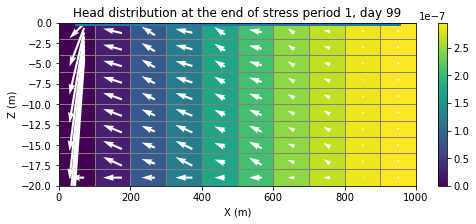

In [45]:
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[0]))
head = headobj.get_data(totim=times_output_list_day[0])
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(head)
grd = modeLx_msect.plot_grid()
ax.plot(dis.get_node_coordinates()[1] , head[-1,0,:], linewidth=5.0)
plt.colorbar(arr, shrink=1, ax=ax)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times_output_list_day[0])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times_output_list_day[0])[0]
modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)

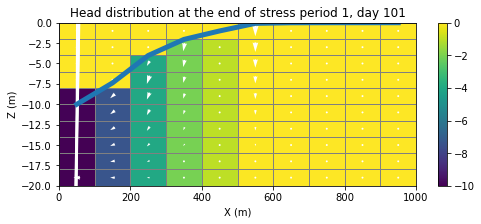

In [44]:

# %% Plot the Head distribution at the end of stress period 1
#
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[1]))
head = headobj.get_data(totim=times_output_list_day[1])
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(head)
grd = modeLx_msect.plot_grid()
ax.plot(dis.get_node_coordinates()[1] , head[-1,0,:], linewidth=5.0)
plt.colorbar(arr, shrink=1, ax=ax)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times_output_list_day[1])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times_output_list_day[1])[0]
modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)

%% Plot the Head distribution at the end of stress period 2<br>


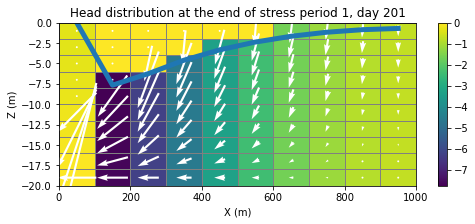

In [43]:
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[2]))
head = headobj.get_data(totim=times_output_list_day[2])
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(head)
grd = modeLx_msect.plot_grid()
ax.plot(dis.get_node_coordinates()[1], head[-1,0,:], linewidth=5.0,)
plt.colorbar(arr, shrink=1, ax=ax)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[4])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times[4])[0]
modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)

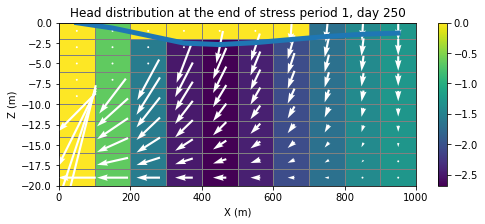

In [42]:
#CMsurf = ax.plot_surface(modeLx_msect.xcenters, modeLx_msect.xcenters, head[:,0,:], cmap=cm.coolwarm,
#CM                       linewidth=0, antialiased=False)
# %% Plot the Head distribution at the end of stress period 3
#
fig = plt.figure(figsize=(8, 3))
ax  = fig.add_subplot(1, 1, 1)
t   = ax.set_title('Head distribution at the end of stress period 1, day %i' %(times_output_list_day[3]))
head = headobj.get_data(totim=times_output_list_day[3])
modeLx_msect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 0})
arr = modeLx_msect.plot_array(head)
grd = modeLx_msect.plot_grid()
ax.plot(dis.get_node_coordinates()[1] , head[-1,0,:], linewidth=5.0,)
plt.colorbar(arr, shrink=1, ax=ax)
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
times = cbbobj.get_times()
qx = cbbobj.get_data(text="flow right face", totim=times[5])[0]
qy = np.zeros((nlay, nrow, ncol), dtype=float)
qz = cbbobj.get_data(text="flow lower face", totim=times[5])[0]
modeLx_msect.plot_vector(qx, qy, -qz, color="white", kstep=1, hstep=1)